<a href="https://colab.research.google.com/github/bjackson2022/BigDataBandits-store-sales-predictions/blob/main/Promotional_Data_Visualizations_Time_Series_Forecast__Brandyn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Key Visualizations & Machine Learning:** Time Series + Random Forest
---



## Load in Dependencies, basic EDA
**Data Prep/ETL Process**
- **Extract** the data (.csv files) via **<library used here>**
- **Transform** visa joins
- **Load** into pandas dataframe

In [ ]:
!python -m pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 KB 3.2 MB/s eta 0:00:00
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [ ]:
# Importing required libraries/dependencies
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from prophet import Prophet
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
get_ipython().run_line_magic('matplotlib', 'inline')
import itertools
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd, datetime
from pandas import DataFrame
import seaborn as sns
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sqlalchemy import create_engine
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from time import time
from unicodedata import normalize
import xgboost as xgb

Mounted at /gdrive
/gdrive


In [ ]:
#  Import and read the csv via Google drive
grocery_training_data_df = pd.read_csv('/gdrive/MyDrive/GT Data Science Bootcamp/Project_4-Big_Data_Bandits/grocery_train.csv')
grocery_training_data_df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [ ]:
#Pass in csv files and load as dataframe
holidays_events_df = pd.read_csv('/gdrive/MyDrive/GT Data Science Bootcamp/Project_4-Big_Data_Bandits/holidays_events.csv')
holidays_events_df['date'] = pd.to_datetime(holidays_events_df['date'])
holidays_events_df['year'] = holidays_events_df['date'].dt.year
holidays_events_df['date'] = holidays_events_df['date'].dt.strftime('%Y-%m-%d')
holidays_events_df.head()

,date,type,locale,locale_name,description,transferred,year
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,2012
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,2012
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,2012
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,2012
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,2012


In [ ]:
# Converts the 'date' column into usable parameters for both visualization & time series modeling

#converts promo sales units into o1's or 0's based on if sales volume > 0 
grocery_training_data_df['onpromotion'] = grocery_training_data_df['onpromotion'].apply(lambda x: 1 if x > 0 else 0)

#converts 'date' column to datetime
grocery_training_data_df['date'] = pd.to_datetime(grocery_training_data_df['date'])

#adds in numerical day of the week
grocery_training_data_df['day_of_week'] = grocery_training_data_df['date'].dt.weekday + 1

#adds in month
grocery_training_data_df['month'] = grocery_training_data_df['date'].dt.month

#adds in mon-year
grocery_training_data_df['mon-year'] = grocery_training_data_df['date'].dt.strftime('%b-%Y')

grocery_training_data_df

,id,date,store_nbr,family,sales,onpromotion,day_of_week,month,mon-year
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,2,1,Jan-2013
1,1,2013-01-01,1,BABY CARE,0.000,0,2,1,Jan-2013
2,2,2013-01-01,1,BEAUTY,0.000,0,2,1,Jan-2013
3,3,2013-01-01,1,BEVERAGES,0.000,0,2,1,Jan-2013
4,4,2013-01-01,1,BOOKS,0.000,0,2,1,Jan-2013
...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,2,8,Aug-2017
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2,8,Aug-2017
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,1,2,8,Aug-2017
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,1,2,8,Aug-2017


## Data Visualizations: Promotional Data Analysis

C:\Users\Brandyn Jackson\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


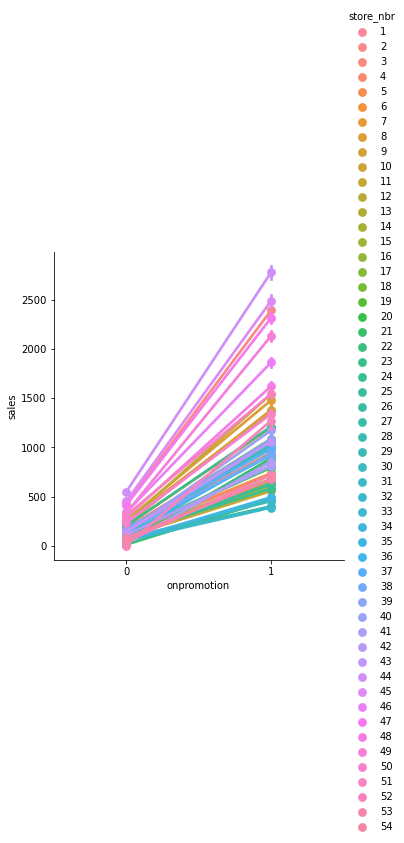

In [ ]:
#shows how often we promo categorized by store and if we have more sales...IMPORTANT remember to change factorplot to catplot ********!!!!!!!!!!!!!!DO NOT RE-RUN THIS CELL (stick with saved output) TAKES FOREVER!!!!!!!!!!****************
sns.factorplot(data= grocery_training_data_df, 
               x= 'onpromotion',
               y= 'sales',
               hue= 'store_nbr');

C:\Users\Brandyn Jackson\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


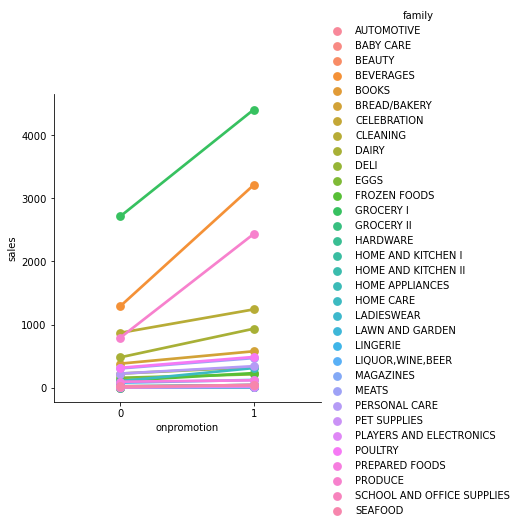

In [ ]:
#shows how often we promo categorized by product type or 'family' and if we have more sales...IMPORTANTremember to change factorplot to catplot ********!!!!!!!!!!!!!!DO NOT RE-RUN THIS CELL (stick with saved output) TAKES FOREVER!!!!!!!!!!****************
sns.factorplot(data= grocery_training_data_df, 
               x= 'onpromotion',
               y= 'sales',
               hue= 'family');

## Data Visualizations: Holiday Types:

---




In [ ]:
holidays_df = holidays_events_df[holidays_events_df['type'] == 'Holiday']
holidays_df.loc[:, 'date'] = pd.to_datetime(holidays_df['date'])
holidays_df.loc[:, 'year'] = holidays_df['date'].dt.year
holidays_df.loc[:, 'date'] = holidays_df['date'].dt.strftime('%Y-%m-%d')
# holidays_df

C:\Users\Brandyn Jackson\AppData\Local\Temp\ipykernel_31660\784647046.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays_df.loc[:, 'date'] = pd.to_datetime(holidays_df['date'])
C:\Users\Brandyn Jackson\AppData\Local\Temp\ipykernel_31660\784647046.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays_df.loc[:, 'year'] = holidays_df['date'].dt.year
C:\Users\Brandyn Jackson\AppData\Local\Temp\ipykernel_31660\784647046.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [ ]:
holidays_events_summary_df = holidays_events_df.groupby(["year", "type", "locale"])["date"].count()
holidays_events_summary_df = holidays_events_summary_df.unstack(level=-1)
holidays_events_summary_df = holidays_events_summary_df.fillna('')
holidays_events_summary_df.head()

locale          Local  National Regional
year type                               
2012 Additional   1.0       6.0         
     Bridge                 2.0         
     Holiday     22.0       5.0      4.0
     Transfer               1.0         
2013 Additional   2.0       7.0

In [ ]:
# Filter data frame for year 2016
yr_2016_holidays_df = holidays_df[holidays_df['year'] == 2016].copy()
yr_2016_holidays_df.head()

,date,type,locale,locale_name,description,transferred,year
211,2016-01-01,Holiday,National,Ecuador,Primer dia del ano,False,2016
212,2016-02-08,Holiday,National,Ecuador,Carnaval,False,2016
213,2016-02-09,Holiday,National,Ecuador,Carnaval,False,2016
214,2016-03-02,Holiday,Local,Manta,Fundacion de Manta,False,2016
215,2016-03-25,Holiday,National,Ecuador,Viernes Santo,False,2016


In [ ]:
# Get the count of each holiday type
total_holiday_counts = yr_2016_holidays_df['locale'].value_counts()
total_holiday_counts

Local       23
National    11
Regional     4
Name: locale, dtype: int64

In [ ]:
# Get the count # of holidays by locale type
locale_name_holiday_counts = yr_2016_holidays_df['locale_name'].value_counts()
locale_name_holiday_counts.head()

Ecuador      11
Riobamba      2
Guaranda      2
Latacunga     2
Ambato        2
Name: locale_name, dtype: int64

------

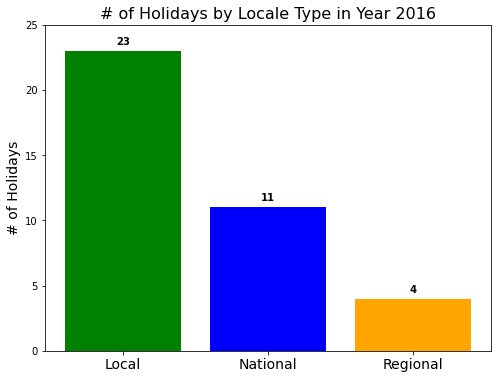

In [ ]:
# Create a dictionary of colors for each locale type
colors = {'National': 'blue', 'Regional': 'orange', 'Local': 'green'}

# Create a bar chart
fig, ax = plt.subplots(figsize=(8,6))
for i, locale in enumerate(total_holiday_counts.index):
    ax.bar(i, total_holiday_counts[locale], color=colors[locale])
    ax.text(i, total_holiday_counts[locale]+0.5, str(total_holiday_counts[locale]), ha='center', fontweight='bold')

# Set chart title and labels
ax.set_title('# of Holidays by Locale Type in Year 2016', fontsize=16)
# ax.set_xlabel('Holiday Type', fontsize=14)
ax.set_ylabel('# of Holidays', fontsize=14)

# Set x-axis tick labels and position
ax.set_xticks(range(len(total_holiday_counts.index)))
ax.set_xticklabels(total_holiday_counts.index, fontsize=14)

# Set y-axis range
ax.set_ylim([0, 25])

# Show the chart
plt.show()

------

## **Visualizing the Data by Location**
- Use plotly to visualize the data

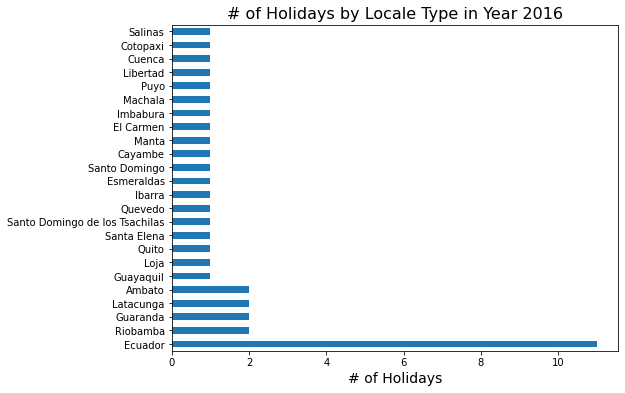

In [ ]:
# create a bar chart
fig, ax = plt.subplots(figsize=(8, 6))

# Create a horizontal bar chart using the `plot.barh()` method
locale_name_holiday_counts.plot.barh(ax=ax)
# create bins
bins = [0, 1, 2, np.inf]
bin_labels = ['Bin 1 (0-1)', 'Bin 2 (1-2)', 'Bin 3 (>2)']
locale_name_holiday_counts_binned = pd.cut(locale_name_holiday_counts, bins=bins, labels=bin_labels)

# Set the chart title and axis labels
ax.set_title('# of Holidays by Locale Type in Year 2016', fontsize=16)
ax.set_xlabel("# of Holidays", fontsize=14)
# ax.set_ylabel("Locale name", fontsize=12)

# Display the chart
plt.show()

# Machine Learning - Time Series Analysis using Prophet
https://facebook.github.io/prophet/
---

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg504_hmb/_aip0wvc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg504_hmb/2184wr1b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8597', 'data', 'file=/tmp/tmpg504_hmb/_aip0wvc.json', 'init=/tmp/tmpg504_hmb/2184wr1b.json', 'output', 'file=/tmp/tmpg504_hmb/prophet_modelgolnmgrv/prophet_model-20230307003810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:38:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:38:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


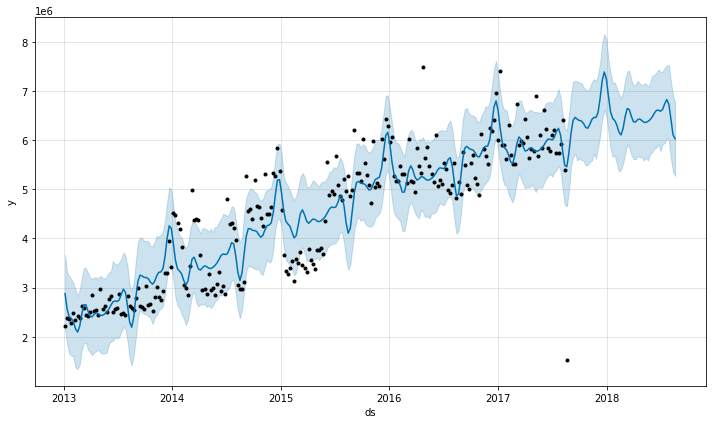

In [ ]:
# Convert date column to datetime type
grocery_training_data_df['date'] = pd.to_datetime(grocery_training_data_df['date'])

# Group data by week and sum the sales values
weekly_sales = grocery_training_data_df.groupby(pd.Grouper(key='date', freq='W'))['sales'].sum().reset_index()

# Rename columns as required by Prophet
weekly_sales = weekly_sales.rename(columns={'date': 'ds', 'sales': 'y'})

# Create and fit Prophet model
m = Prophet()
m.fit(weekly_sales)

# Generate future dataframe with weekly dates for forecasting
future = m.make_future_dataframe(periods=52, freq='W')

# Make predictions
forecast = m.predict(future)

# Plot the forecast
fig = m.plot(forecast)

In [ ]:
# Checking the RMSE of Prophet model
rmse = np.sqrt(mean_squared_error(weekly_sales['y'], forecast['yhat'][:len(weekly_sales)]))
rmse

592788.108415033

## Machine Learning - Random Forest Regressor

In [ ]:
# Import libraries
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# #  Import and read the csv via Google drive
# grocery_training_data_df = pd.read_csv('/gdrive/MyDrive/GT Data Science Bootcamp/Project_4-Big_Data_Bandits/grocery_train.csv')
# grocery_training_data_df


# Preprocess data
X = grocery_training_data_df[['store_nbr', 'family', 'onpromotion']] # Features
y = grocery_training_data_df['sales'] # Target variable
X = pd.get_dummies(X) # One-hot encode categorical variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Split into train and test sets

In [ ]:
# Train model...be warned, any 'n_estimators > 10 will take quote some time to run!!
rf = RandomForestRegressor(n_estimators=10, random_state=42) # Initialize model
rf.fit(X_train, y_train) # Fit model to training data

RandomForestRegressor(n_estimators=10, random_state=42)

In [ ]:
# Evaluate model
y_pred = rf.predict(X_test) # Predict on test data
mse = mean_squared_error(y_test, y_pred) # Calculate mean squared error
print("Mean Squared Error:", mse)

Mean Squared Error: 220537.310253622
